In [1]:
import torch
import numpy as np

train_on_gpu=torch.cuda.is_available()

In [2]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler


## 这里可以调整参数
number_of_workers = 1
batch_size= 10
valid_size= 0.2


## 这里可以更改数据集的处理
#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])

In [3]:
# Downloading training and testing Datasets
train_data= datasets.CIFAR10('data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]

In [5]:
# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size, 
                                         num_workers= number_of_workers)

In [7]:
# After preparing Data, we have to unnormalize it to visullize it.
# Lets create a helper function which will un-normalize all the images
import matplotlib.pyplot as plt

def imshow(img):
  # Will take numpy array as input
  img = img / 2 + 0.5 # Unnormalize image，参照上面transforms.Normalize进行调整
  plt.imshow(np.transpose(img, (1, 2, 0))) # img array , axis in tuple(numbers indicates the location of new image shape.) Converting from tensor image 

In [8]:
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

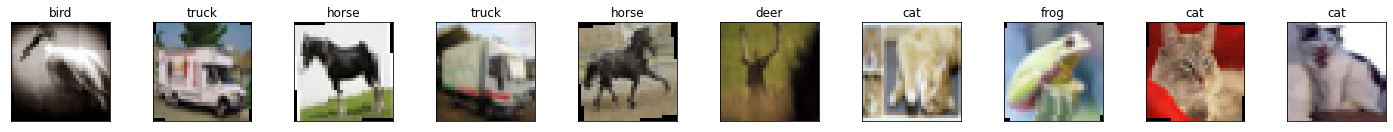

In [107]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(10):
  ax= fig.add_subplot(2 , 10 , idx+1 , xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])

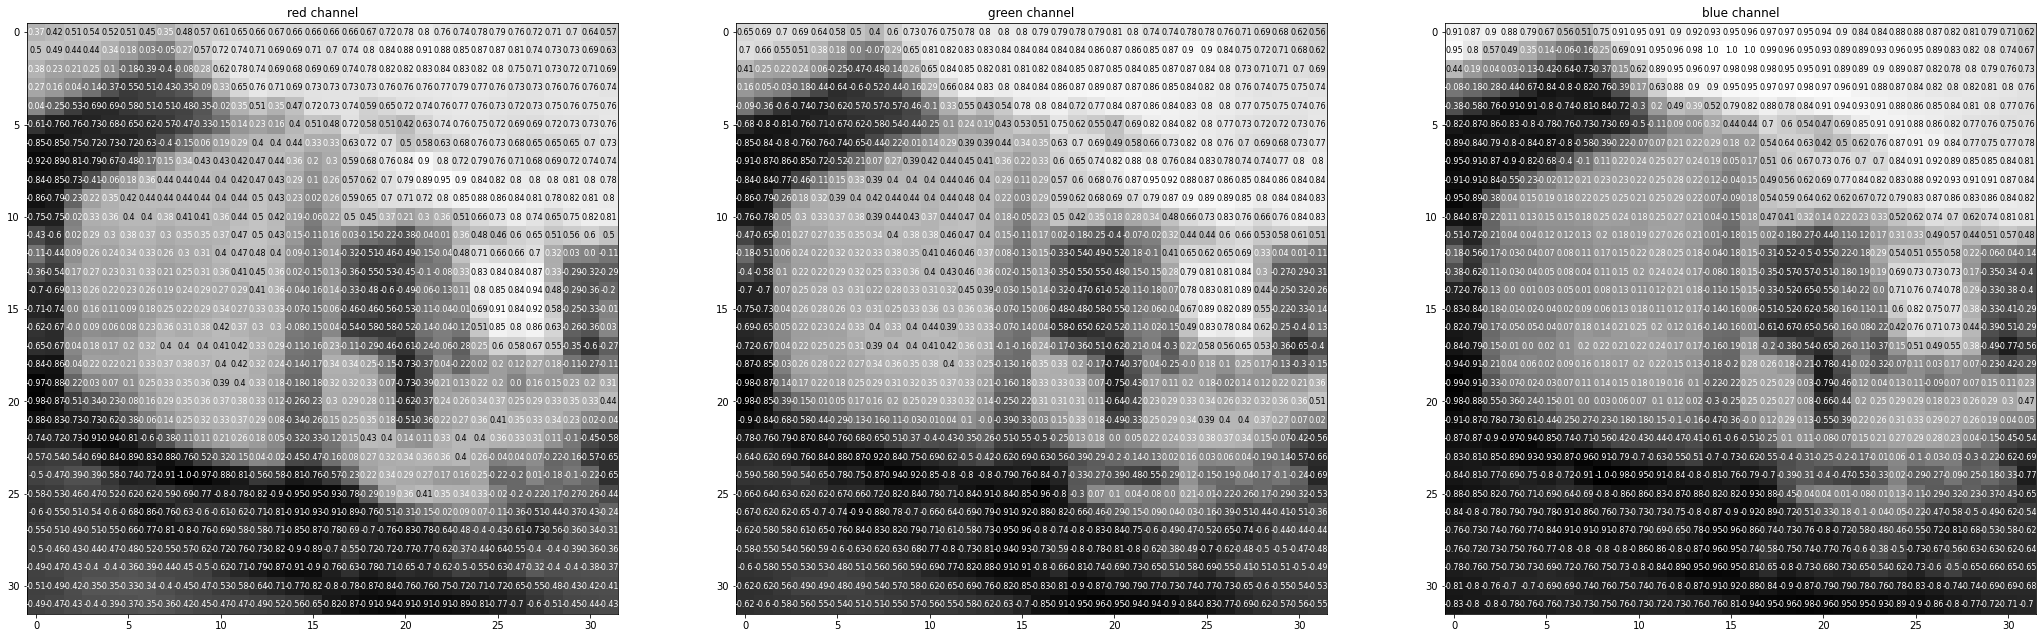

In [108]:
## 取上面那一行图片中的第四个拆分rgb图层
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [22]:
import torch.nn as nn
import torch.nn.functional as F

## 这里可以调整很多参数，比如每层的大小、种类等等
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input image size is 32*32, output size of conv2d is: (input_size-kernal_size+2*padding)/stride +1
        self.conv1 = nn.Conv2d(3, 6, 2 , padding=1, stride= 1) # the third param means 2*2 conv_kernal
        self.pool1 = nn.MaxPool2d(2, 2) # 2*2 pooling window
        self.conv2 = nn.Conv2d(6, 16, 2, padding=1, stride= 1) 
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d(16, 32, 2, stride= 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(4, 4)) # global average pool replaces linear connection
#         self.fc1 = nn.Linear(32* 3**2, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
        self.fc = nn.Linear(288, 10) # output layer
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool1( F.relu(self.conv1(x)))
        x= self.pool2( F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
#         x= self.global_pool(x)
        # Flatten it
        x= torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)
#         x= F.relu(self.fc1(x))
#         x= F.relu(self.fc2(x))
#         x= self.fc3(x)
        x = self.fc(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=288, out_features=10, bias=True)
)


In [23]:
import torch.optim as optim
import time


# # Define label smoothing loss class
# class LabelSmoothLoss(nn.Module):
#     def __init__(self, epsilon=0.1, reduction='mean', num_classes=10):
#         super(LabelSmoothLoss, self).__init__()
#         self.epsilon = epsilon
#         self.reduction = reduction
#         self.num_classes = num_classes

#     def forward(self, output, target):
#         code = F.one_hot(target, num_classes=self.num_classes).float() # generate one-hot code
#         smooth_target = (1.0 - self.epsilon) * code + self.epsilon / self.num_classes

#         loss = F.kl_div(F.log_softmax(output, dim=1), smooth_target, reduction='none')
#         # deal with the loss
#         if self.reduction == 'mean':
#             return loss.mean()
#         elif self.reduction == 'sum':
#             return loss.sum()
#         else:
#             return loss

# specify loss function
# criterion = LabelSmoothLoss(epsilon=0.1, reduction = 'sum')
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr= 0.0001, momentum= 0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [24]:
## 可以调整迭代次数
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

## Record total training and validation time
start_time = time.time()
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
end_time = time.time()
total_time = end_time - start_time
print("Total time is: "+str(round(total_time,2))+"s")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff2c3de8af0>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 1 	Training Loss: 1.836141 	Validation Loss: 0.456560
Validation loss decreased (inf --> 0.456560).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff2c3de8af0>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/root/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 2 	Training Loss: 1.801203 	Validation Loss: 0.440026
Validation loss decreased (0.456560 --> 0.440026).  Saving model ...
Epoch: 3 	Training Loss: 1.701921 	Validation Loss: 0.412320
Validation loss decreased (0.440026 --> 0.412320).  Saving model ...
Epoch: 4 	Training Loss: 1.629453 	Validation Loss: 0.399508
Validation loss decreased (0.412320 --> 0.399508).  Saving model ...
Epoch: 5 	Training Loss: 1.579152 	Validation Loss: 0.387907
Validation loss decreased (0.399508 --> 0.387907).  Saving model ...
Epoch: 6 	Training Loss: 1.529749 	Validation Loss: 0.379134
Validation loss decreased (0.387907 --> 0.379134).  Saving model ...
Epoch: 7 	Training Loss: 1.489848 	Validation Loss: 0.367518
Validation loss decreased (0.379134 --> 0.367518).  Saving model ...
Epoch: 8 	Training Loss: 1.458655 	Validation Loss: 0.359052
Validation loss decreased (0.367518 --> 0.359052).  Saving model ...
Epoch: 9 	Training Loss: 1.430546 	Validation Loss: 0.353041
Validation loss decreased (0.

In [25]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

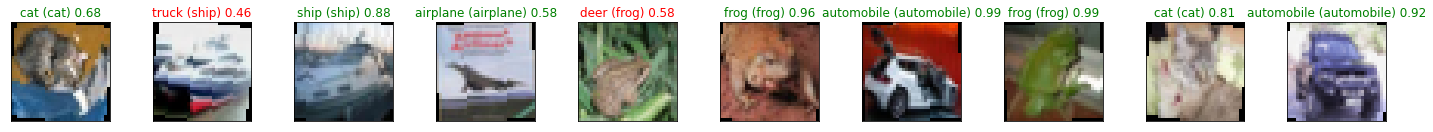

In [37]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

# calculate the confidence value
confidence = F.softmax(output, dim = -1)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, axis = 1) # 数组包含每个样本的最大预测值
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({}) {:.2f}".format(class_names[preds[idx]], class_names[labels[idx]], confidence[idx, preds[idx]].item()),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))